In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, warnings
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import DATA_DIR, ROOT_DIR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings("ignore", category=RuntimeWarning) # supress function fitting warnings
pd.set_option('display.max_columns', None) # display all pandas cols

### Data Decide Evals

In [12]:
from download.hf import pull_predictions_from_hf
from pathlib import Path

local_path = f'{DATA_DIR}/consistent_ranking/data/benchmarks-00000-of-00001.parquet'
df = pd.read_parquet(local_path)
print(f'Loaded {len(df):,} model evaluations')

local_path = f'{DATA_DIR}/consistent_ranking_small/data/benchmarks-00000-of-00001.parquet'
df_small = pd.read_parquet(local_path)
print(f'Loaded {len(df_small):,} model evaluations')

df = pd.concat([df, df_small], ignore_index=True)

df['mix'] = df['group']

Loaded 201,113 model evaluations
Loaded 61,721 model evaluations


In [4]:
# Only keep the random seeds for fully complete model runs
large_sizes = ['530M', '750M', '1B']
df = pd.concat([
    df[~df['size'].isin(large_sizes)],
    df[(df['size'].isin(large_sizes)) & (df['seed'] == 6198)]
])

In [5]:
MIXES = df['group'].unique()
SIZES = df['size'].unique()
MULT  = df['chinchilla'].unique()
SEEDS = df['seed'].unique()

MODELS = df['model'].unique()
TASKS  = df['task'].unique()

METRICS_RC= [
    'primary_metric', 'correct_prob', 'correct_prob_per_token', 'correct_prob_per_char', 'margin', 'margin_per_token', 'margin_per_char', 'total_prob', 'total_prob_per_token', 'total_prob_per_char', 'uncond_correct_prob', 'uncond_correct_prob_per_token', 'uncond_correct_prob_per_char', 'norm_correct_prob', 'norm_correct_prob_per_token', 'norm_correct_prob_per_char',
    'acc_raw', 'acc_per_token', 'acc_per_char', 'acc_uncond'
]

# Sort SIZES
sizes_numeric = []
for size in SIZES:
    if size.endswith('B'):
        sizes_numeric.append(float(size[:-1]) * 1000)
    else:
        sizes_numeric.append(float(size[:-1]))
SIZES = SIZES[np.argsort(sizes_numeric)]

# Default seed
SEED = 6198

# Default setup
selected_tasks = TASKS
metric = 'primary_metric'

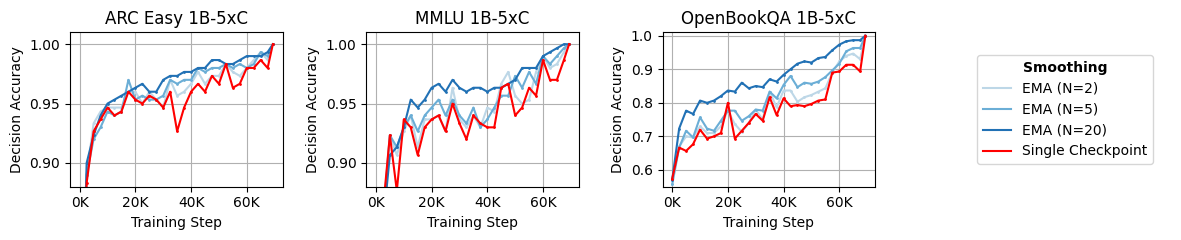

In [6]:
from datadecide import decision_acc_fast
from dataloader import get_slice
from utils import PLOT_DIR, get_pretty_task_name

# plotted_tasks = TASKS
plotted_tasks = ['arc_easy', 'mmlu', 'openbookqa']

n_cols = 4
n_rows = (len(plotted_tasks) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2.5*n_rows))
axes = axes.flatten()

for task_idx, task in enumerate(plotted_tasks):
    ax: plt.Axes = axes[task_idx]
    
    steps = []
    scores = []
    for mix in MIXES:
        curve_data = get_slice(df, mix=mix, task=task, size='1B', seed=SEED)
        step = curve_data['step'].to_numpy()
        score = curve_data[metric].to_numpy()
        scores.append(score)
        steps.append(step)
    scores = np.array(scores)
    steps = np.array(steps)

    # Calculate decision accuracy with original scores
    orig_decision_accs = [decision_acc_fast(scores[:, i], scores[:, -1]) for i in range(scores.shape[1])]

    # Apply EMA with different spans
    spans = [2, 5, 20]
    # spans = [20, 50, 100]
    colors = ['#BDD7E7', '#6BAED6', '#2171B5']  # Light, medium, dark blue
    for span, color in zip(spans, colors):
        ema_scores = np.zeros_like(scores)
        for i in range(len(scores)):
            ema_scores[i] = pd.Series(scores[i]).ewm(span=span).mean()
            # ema_scores[i] = pd.Series(scores[i]).rolling(window=span, min_periods=1).mean()

        ema_decision_accs = [decision_acc_fast(ema_scores[:, i], ema_scores[:, -1]) for i in range(ema_scores.shape[1])]
        ax.plot(steps[0], ema_decision_accs, marker='o', markersize=1, label=f'EMA (N={span})', color=color)

    ax.plot(steps[0], orig_decision_accs, marker='o', markersize=1, label='Single Checkpoint', color='red')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Decision Accuracy')
    ax.set_title(f'{get_pretty_task_name(task)} 1B-5xC')
    ax.grid(True)

    if task in ['arc_challenge', 'arc_easy', 'mmlu', 'hellaswag']:
        ax.set_ylim(bottom=0.88, top=1.01)
    else:
        ax.set_ylim(bottom=0.55, top=1.01)

    ax.set_xticks([0, 20000, 40000, 60000])
    xticks = ax.get_xticks()
    ax.set_xticklabels([f'{int(x/1000)}K' for x in xticks])

# Put legend on the last (empty) subplot
legend_ax = axes[-1]
legend_ax.set_visible(True)
legend_ax.axis('off')
lines = []
labels = []
for span, color in zip(spans, colors):
    lines.append(plt.Line2D([0], [0], color=color, label=f'EMA (N={span})'))
lines.append(plt.Line2D([0], [0], color='red', label='Single Checkpoint'))
legend = legend_ax.legend(handles=lines, loc='center', title='Smoothing')
legend.get_title().set_weight('bold')

for idx in range(task_idx + 1, len(axes)-1):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/smoothing_acc.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [8]:
metric = 'primary_metric'

In [9]:
from dataloader import get_slice
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

metrics_list = []
for task in tqdm(selected_tasks):
    for seed in SEEDS:
        for mix in MIXES:
            for size in SIZES:
                curve_data = get_slice(df, mix=mix, task=task, size=size, seed=seed)
                if curve_data.empty: continue

                curve_data = curve_data.sort_values('step')
                curve_values = curve_data[metric].values
                
                # Compute total variation
                step_changes = np.abs(np.diff(curve_values)).mean()
                first_3_avg = np.mean(curve_values[:3])
                last_3_avg  = np.mean(curve_values[-3:])
                total_variation = step_changes - ((last_3_avg - first_3_avg)/len(curve_values))

                # Calculate standard deviation and count of steps in last X% of checkpoints
                last_vals = curve_values[int(-0.3 * len(curve_values)):]
                step_std = np.std(last_vals)
                step_n = len(last_vals)
                
                # Calculate final score (avg of last X)
                final_score = np.mean(curve_values[int(-0.1 * len(curve_values)):])
                score_last_1 = curve_values[-1]

                # Calculate monotonicity
                steps = np.arange(len(curve_values))
                monotonicity, _ = spearmanr(steps, curve_values)
                
                metrics_list.append({
                    'task': task,
                    'mix': mix,
                    'size': size, 
                    'seed': seed,
                    'score': final_score,
                    'score_last_n': final_score,
                    'score_last_1': score_last_1,
                    'step_std': step_std,
                    'step_n': step_n,
                    'total_variation': total_variation,
                    'monotonicity': monotonicity
                })

metrics_df = pd.DataFrame(metrics_list)

100%|██████████| 11/11 [01:02<00:00,  5.72s/it]


In [10]:
# Calculate aggregated stats
agg_stats = metrics_df.groupby(['task', 'size', 'seed'])['score'].agg([
    'mean',
    'std'
]).reset_index()

# Calculate range and z-score separately to ensure proper aggregation
range_stats = metrics_df.groupby(['task', 'size', 'seed'])['score'].agg(
    range=lambda x: x.max() - x.min()
).reset_index()

metrics_df = metrics_df.merge(agg_stats, on=['task', 'size', 'seed'], how='left')
metrics_df = metrics_df.merge(range_stats, on=['task', 'size', 'seed'], how='left')

metrics_df['z_score'] = metrics_df.groupby(['task', 'size', 'seed'])['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [11]:
from scipy.stats import pearsonr
from stats import compute_decision_accuracy

# Calculate decision accuracy
mix_order_correlations = []
for seed in SEEDS:
    for task in selected_tasks:
        for size in SIZES:
            score_1b = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == '1B')] # only one seed at the target scale
            score_size = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == size) & (metrics_df['seed'] == seed)]

            if score_size.empty:
                continue

            # Get the mix orders and scores
            score_1b_sorted   = score_1b.sort_values('score', ascending=False).reset_index(drop=True)
            score_size_sorted = score_size.sort_values('score', ascending=False).reset_index(drop=True)
            mixes_1b          = score_1b_sorted['mix'].tolist()
            mixes_size        = score_size_sorted['mix'].tolist()
            scores_1b         = score_1b_sorted['score'].tolist()
            scores_size       = score_size_sorted['score'].tolist()
            decision_accuracy = compute_decision_accuracy(mixes_1b, mixes_size)
            
            # Calculate Pearson correlation
            common_mixes       = list(set(mixes_1b) & set(mixes_size))
            scores_1b_common   = [scores_1b[mixes_1b.index(mix)] for mix in common_mixes]
            scores_size_common = [scores_size[mixes_size.index(mix)] for mix in common_mixes]
            pearson_corr, _    = pearsonr(scores_1b_common, scores_size_common)

            mix_order_correlations.append({
                'task': task,
                'size': size,
                'seed': seed,
                'mix_order_correlation': decision_accuracy,
                'mix_order_pearson_correlation': pearson_corr,
            })

# Add to metrics_df
correlation_df = pd.DataFrame(mix_order_correlations)
metrics_df = metrics_df.merge(correlation_df, on=['task', 'size', 'seed'], how='left', suffixes=('_y', ''))
metrics_df = metrics_df.drop([col for col in metrics_df.columns if col.endswith('_y')], axis=1)

In [12]:
from scipy import stats

# Calculate seed correlation (agreement between seeds at same size)
seed_correlations = []
for task in selected_tasks:
    for size in SIZES:
        # Skip since it only has one seed
        if size == '1B' or size == '760M' or size == '530M':
            continue
            
        score_size = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == size)]
        
        if score_size.empty:
            continue

        # Get orderings for each seed
        seed_orders = {}
        for seed in SEEDS:
            seed_scores = score_size[score_size['seed'] == seed]
            if not seed_scores.empty:
                seed_scores_sorted = seed_scores.sort_values('score', ascending=False).reset_index(drop=True)
                seed_orders[seed] = seed_scores_sorted['mix'].tolist()
        
        # Compare pairs of seeds
        agree_count = 0
        total_pairs = 0
        seed_pairs = [(s1, s2) for i, s1 in enumerate(seed_orders.keys()) for s2 in list(seed_orders.keys())[i+1:]]
        
        for seed1, seed2 in seed_pairs:
            mixes1 = seed_orders[seed1]
            mixes2 = seed_orders[seed2]
            
            # Count pairs that agree in relative ordering
            for i in range(len(mixes1)):
                for j in range(i+1, len(mixes1)):
                    mix1, mix2 = mixes1[i], mixes1[j]
                    # Find positions of same mixes in other seed's ordering
                    try:
                        pos1 = mixes2.index(mix1)
                        pos2 = mixes2.index(mix2)
                        # Check if relative ordering agrees
                        if (pos1 < pos2) == (i < j):
                            agree_count += 1
                        total_pairs += 1
                    except ValueError:
                        continue

        seed_correlation = agree_count / total_pairs if total_pairs > 0 else 0
        
        # Get scores for each seed
        seed_scores = []
        for seed in seed_orders:
            seed_scores.extend([score_size[score_size['seed'] == seed]['score'].values[0]])
        
        seed_scores = np.array(seed_scores)
        seeed_n = len(seed_scores)
        seed_std = np.std(seed_scores)
        seed_range = np.max(seed_scores) - np.min(seed_scores)
        seed_zscore = np.mean(np.abs(stats.zscore(seed_scores)))
        
        seed_correlations.append({
            'task': task,
            'size': size,
            'seed_correlation': seed_correlation,
            'seed_n': seeed_n,
            'seed_std': seed_std,
            'seed_range': seed_range, 
            'seed_zscore': seed_zscore
        })

# Add to metrics_df
correlation_df = pd.DataFrame(seed_correlations)
metrics_df = metrics_df.merge(correlation_df, on=['task', 'size'], how='left', suffixes=('_y', ''))
metrics_df = metrics_df.drop([col for col in metrics_df.columns if col.endswith('_y')], axis=1)

In [13]:
SEED = 6198

# Calculate step correlation (agreement between consecutive checkpoints)
step_correlations = []
for task in selected_tasks:
    for size in SIZES:
        # Skip since it only has one seed
        # if size == '1B' or size == '760M' or size == '530M':
        #     continue
            
        # score_size = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == size)]
        score_size = get_slice(df, task=task, size=size, seed=SEED) # seed=SEED, mix=mix
        
        if score_size.empty:
            continue

        assert len(score_size['group'].unique()) > 1, score_size['group'].unique()

        # Get the largest step that exists for all seeds
        all_steps = score_size['step'].unique()
        seed_counts = score_size.groupby('step')['seed'].nunique()
        valid_steps = seed_counts[seed_counts == seed_counts.max()].index
        max_valid_step = max(valid_steps)
        
        # Get orderings for each step (last 5 checkpoints before max_valid_step)
        step_orders = {}
        # valid_steps = sorted([s for s in all_steps if s <= max_valid_step])[-30:] # -50
        valid_steps = sorted([s for s in all_steps if s <= max_valid_step])[-int(len([s for s in all_steps if s <= max_valid_step])*0.8):] # Last 80% of steps
        for step in valid_steps:
            step_scores = score_size[score_size['step'] == step]
            if not step_scores.empty:
                step_scores_sorted = step_scores.sort_values(metric, ascending=False).reset_index(drop=True)
                step_orders[step] = step_scores_sorted['mix'].tolist()
        
        # Compare consecutive pairs of steps
        agree_count = 0
        total_pairs = 0
        steps = sorted(step_orders.keys())
        step_pairs = [(steps[i], steps[j]) for i in range(len(steps)) for j in range(i+1, len(steps))]  # Create all possible pairs of steps

        # TODO: Compute rank correlation for ever possible selection of the last 10% of steps (for small models, a few steps is a lot by percent)
        
        for step1, step2 in step_pairs:
            mixes1 = step_orders[step1]
            mixes2 = step_orders[step2]
            
            # Count pairs that agree in relative ordering
            for i in range(len(mixes1)):
                for j in range(i+1, len(mixes1)):
                    mix1, mix2 = mixes1[i], mixes1[j]
                    # Find positions of same mixes in other step's ordering
                    try:
                        pos1 = mixes2.index(mix1)
                        pos2 = mixes2.index(mix2)
                        # Check if relative ordering agrees
                        if (pos1 < pos2) == (i < j):
                            agree_count += 1
                        total_pairs += 1
                    except ValueError:
                        continue

        step_correlation = agree_count / total_pairs if total_pairs > 0 else 0
        
        # Get scores for each step
        step_scores = []
        for step in step_orders:
            step_scores.extend([score_size[score_size['step'] == step][metric].values[0]])
        
        step_scores = np.array(step_scores)
        # step_std = np.std(step_scores)
        step_range = np.max(step_scores) - np.min(step_scores)
        from scipy import stats
        step_zscore = np.mean(np.abs(stats.zscore(step_scores)))
        
        step_correlations.append({
            'task': task,
            'size': size,
            'step_correlation': step_correlation,
            # 'step_std': step_std,
            # 'step_range': step_range,
            # 'step_zscore': step_zscore
        })

# Add step correlations to metrics_df
correlation_df = pd.DataFrame(step_correlations)
metrics_df = metrics_df.merge(correlation_df, on=['task', 'size'], how='left', suffixes=('_y', ''))
metrics_df = metrics_df.drop([col for col in metrics_df.columns if col.endswith('_y')], axis=1)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


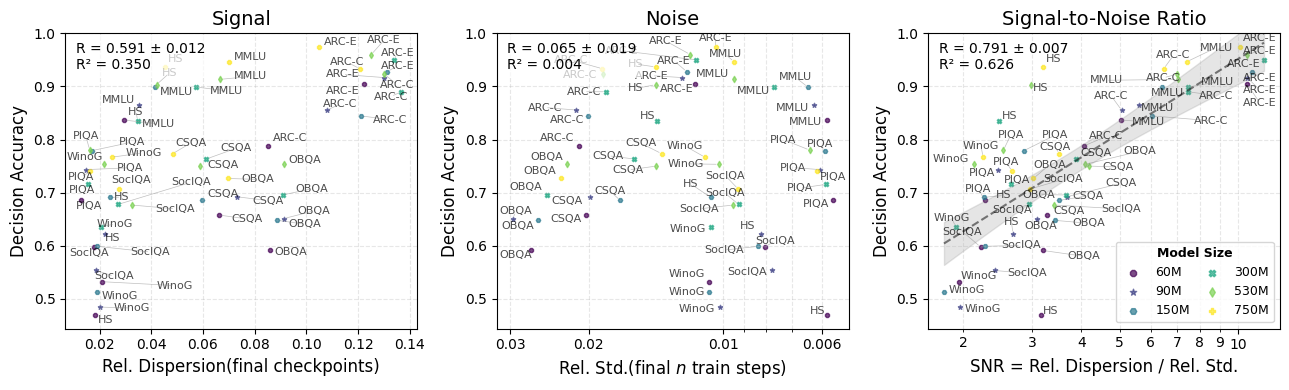

In [14]:
from scipy import stats
from plot import adjustText

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))

sizes = SIZES[7:-1]

from matplotlib.cm import viridis
size_indices = np.linspace(0, 1, len(sizes))
size_colors = {size: viridis(idx) for size, idx in zip(sizes, size_indices)}
size_symbols = {
    '4M': 'o',
    '6M': 's', 
    '8M': '^',
    '10M': 'D',
    '14M': 'v',
    '16M': 'p',
    '20M': 'h',
    '60M': '8',
    '90M': '*',
    '150M': 'H',
    '300M': 'X',
    '530M': 'd',
    '750M': 'P',
    '1B': '<'
}



TASK_PRETTY_NAMES = {
    'arc_challenge': 'ARC-C',
    'arc_easy': 'ARC-E', 
    'boolq': 'BoolQ',
    'csqa': 'CSQA',
    'hellaswag': 'HS',
    'openbookqa': 'OBQA',
    'piqa': 'PIQA',
    'socialiqa': 'SocIQA',
    'winogrande': 'WinoG',
    'mmlu': 'MMLU',
    'olmes_10_macro_avg': 'OLMES-10'
}

all_x_vals1, all_y_vals1, texts1 = [], [], []
all_x_vals2, all_y_vals2, texts2 = [], [], []
all_x_vals3, all_y_vals3, texts3 = [], [], []

for size in sizes:
    x_vals1, y_vals1 = [], []
    x_vals2, y_vals2 = [], []
    x_vals3, y_vals3 = [], []
    tasks = []

    for task in metrics_df['task'].unique():
        # if task == 'hellaswag': continue
        if task == 'olmes_10_macro_avg': continue
        if task == 'boolq': continue

        mix_data = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == size)]
        mix_data_1B = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == '1B')]

        rel_spread        = np.mean(mix_data['std']) / np.mean(mix_data['score'])
        seed_agreement    = np.mean(mix_data['seed_correlation'])
        seed_std          = np.mean(mix_data['seed_std'])
        seed_rel_spread   = np.mean(mix_data['seed_std']) / np.mean(mix_data['score'])
        total_variation   = np.mean(mix_data['total_variation'])
        total_variation_1b = np.mean(mix_data_1B['total_variation'])
        smoothness        = np.mean(mix_data['step_std']) / np.mean(mix_data['score'])
        monotonicity      = np.mean(mix_data['monotonicity'])
        decision_accuracy = np.mean(mix_data['mix_order_correlation'])
        decision_pearson  = np.mean(mix_data['mix_order_pearson_correlation'])
        step_agreement    = np.mean(mix_data['step_correlation'])

        tasks.append(task)
        
        x_vals1.append(rel_spread)
        x_vals2.append(smoothness)
        x_vals3.append(rel_spread/smoothness)
        # x_vals3.append(rel_spread/(rel_spread+smoothness))

        y_vals1.append(decision_accuracy)
        y_vals2.append(decision_accuracy)
        y_vals3.append(decision_accuracy)
        
        all_x_vals1.append(rel_spread)
        all_x_vals2.append(smoothness)
        all_x_vals3.append(rel_spread/smoothness)
        # all_x_vals3.append(rel_spread/(rel_spread+smoothness))

        all_y_vals1.append(decision_accuracy)
        all_y_vals2.append(decision_accuracy)
        all_y_vals3.append(decision_accuracy)

    ax1.scatter(x_vals1, y_vals1, alpha=0.7, label=f'{size}', marker=size_symbols[size], s=10, color=size_colors[size])
    ax2.scatter(x_vals2, y_vals2, alpha=0.7, label=f'{size}', marker=size_symbols[size], s=10, color=size_colors[size])
    ax3.scatter(x_vals3, y_vals3, alpha=0.7, label=f'{size}', marker=size_symbols[size], s=10, color=size_colors[size])
    
    for x1, x2, x3, y, task in zip(x_vals1, x_vals2, x_vals3, y_vals1, tasks):
        pretty_name = TASK_PRETTY_NAMES.get(task, task)
        texts1 += [ax1.text(x1, y, pretty_name, fontsize=8, alpha=0.7)]
        texts2 += [ax2.text(x2, y, pretty_name, fontsize=8, alpha=0.7)]
        texts3 += [ax3.text(x3, y, pretty_name, fontsize=8, alpha=0.7)]

# Configure axes
for ax, x_vals, y_vals, texts, xlabel, title, compute_fit, plot_fit, log_scale in [
    (ax1, all_x_vals1, all_y_vals1, texts1, r'Rel. Dispersion(final checkpoints)', 'Signal', True, False, False),
    (ax2, all_x_vals2, all_y_vals2, texts2, r'Rel. Std.(final $n$ train steps)', 'Noise', True, False, True),
    (ax3, all_x_vals3, all_y_vals3, texts3, 'SNR = Rel. Dispersion / Rel. Std.', 'Signal-to-Noise Ratio', True, True, True),
    # (ax3, all_x_vals3, all_y_vals3, texts3, 'Normalized SNR', True, False),
]:
    ax: plt.Axes
    ax.set_ylim(top=1)
    
    if compute_fit:
        # Add line of best fit with confidence interval
        x_log = np.log10(x_vals)
        z = np.polyfit(x_log, y_vals, 1)
        p = np.poly1d(z)
        x_line = np.logspace(np.log10(min(x_vals)), np.log10(max(x_vals)), 100)
        y_line = p(np.log10(x_line))
        
        n = len(x_vals)
        y_mean = np.mean(y_vals)
        x_mean = np.mean(x_log)
        s_err = np.sqrt(np.sum((y_vals - p(x_log))**2)/(n-2))
        x_new = np.log10(x_line)
        conf = stats.t.ppf(0.975, n-2) * s_err * np.sqrt(1/n + (x_new - x_mean)**2 / np.sum((x_log - x_mean)**2))
        
        r = np.corrcoef(x_log, y_vals)[0,1]
        r2 = r**2
        stderr = s_err * np.sqrt((1-r2)/(n-2))
        if 'SNR' in xlabel:
            background = None
        else:
            background = dict(facecolor='white', alpha=0.7, edgecolor='none')
        ax.text(0.03, 0.97, f'R = {r:.3f} ± {stderr:.3f}\nR² = {r2:.3f}', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=background)
    if plot_fit:
        assert compute_fit
        ax.plot(x_line, y_line, '--', color='black', alpha=0.5)
        ax.fill_between(x_line, y_line-conf, y_line+conf, color='gray', alpha=0.2)

    if log_scale:
        ax.set_xscale('log')
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Decision Accuracy', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3, which='both')
    
    adjustText(ax, texts)

ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x)))

ax2.invert_xaxis()
ax2.set_xticks([0.03, 0.02, 0.01, 0.006])
ax2.set_xticklabels(['0.03', '0.02', '0.01', '0.006'])

ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:d}'.format(int(x))))
ax3.xaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: '{:d}'.format(int(x))))

ax3.legend(ncols=2, title='Model Size', title_fontproperties={'weight': 'bold', 'size': 9}, fontsize=9, loc='lower right', columnspacing=0.7, markerscale=1.5)

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/small_scale_noise.pdf', bbox_inches='tight')
plt.show()

### In-loop Random Seed Data

In [29]:
df_in_loop = pd.read_parquet(f"{DATA_DIR}/random_seeds/olmo2_random_seeds.parquet")

df_in_loop = df_in_loop[~df_in_loop['run_name'].str.contains('4932', na=False)] # incomplete run
# df_in_loop = df_in_loop[~df_in_loop['run_name'].str.contains('high-eval-interval', na=False)] # ignore this run
def get_run_type(run_name: str) -> str:
    if 'data-seed' in str(run_name):
        return 'data'
    elif 'high-eval-interval' in str(run_name):
        return 'high-eval'
    else:
        return 'seed'

df_in_loop['run_type'] = df_in_loop['run_name'].apply(get_run_type)

In [30]:
# Filter to keep only data-seed runs that reach at least 71500 steps
data_seed_df = df_in_loop[df_in_loop['run_type'] == 'data']
data_seed_df = data_seed_df[data_seed_df['step'] <= 71500]
max_steps = data_seed_df.groupby('run_name')['step'].max()
valid_runs = max_steps[max_steps == 71500].index
data_seed_df = data_seed_df[data_seed_df['run_name'].isin(valid_runs)]

# Get max steps for all runs
df_filtered = pd.concat([
    df_in_loop[df_in_loop['run_type'] != 'data'],
    data_seed_df
])
df_in_loop = df_filtered
df_filtered.groupby('run_name')['step'].max()

run_name
OLMo2-1029-1B-5xC                       81000
OLMo2-1304-1B-5xC                       81000
OLMo2-2435-1B-5xC                       81000
OLMo2-2435-high-eval-interval-1B-5xC    81340
OLMo2-3004-1B-5xC                       81000
OLMo2-3043-1B-5xC                       81000
OLMo2-4921-1B-5xC                       81000
OLMo2-5093-1B-5xC                       81000
OLMo2-5730-1B-5xC                       81000
OLMo2-5794-1B-5xC                       81000
OLMo2-9258-1B-5xC                       81000
OLMo2-data-seed-01345-1B-5xC            71500
OLMo2-data-seed-23095-1B-5xC            71500
OLMo2-data-seed-28530-1B-5xC            71500
OLMo2-data-seed-39240-1B-5xC            71500
OLMo2-data-seed-40593-1B-5xC            71500
OLMo2-data-seed-59430-1B-5xC            71500
OLMo2-data-seed-59602-1B-5xC            71500
OLMo2-data-seed-60439-1B-5xC            71500
OLMo2-data-seed-89632-1B-5xC            71500
Name: step, dtype: int64

In [18]:
metric_names = [
    'eval/downstream/hellaswag_rc_5shot (length-normalized accuracy)',
    'eval/downstream/mmlu_test_rc_5shot (length-normalized accuracy)',
    'eval/downstream/arc_challenge_test_rc_5shot (length-normalized accuracy)',
]

MMLU_WEIGHTS = {
    "eval/downstream_bpb/mmlu_stem_var_bpb_bpb": 0.215,
    "eval/downstream_bpb/mmlu_humanities_var_bpb_bpb": 0.335,
    "eval/downstream_bpb/mmlu_social_sciences_var_bpb_bpb": 0.219,
    "eval/downstream_bpb/mmlu_other_var_bpb_bpb": 0.231,
}

MMLU_KEY_WEIGHTS = {
    'eval/downstream/mmlu_other_test_rc_5shot (length-normalized accuracy)': 0.231,
    'eval/downstream/mmlu_social_sciences_test_rc_5shot (length-normalized accuracy)': 0.219,
    'eval/downstream/mmlu_stem_test_rc_5shot (length-normalized accuracy)': 0.215,
    'eval/downstream/mmlu_humanities_test_rc_5shot (length-normalized accuracy)': 0.335,
}

In [19]:
# Compute MMLU macro-average
mmlu_metrics = df_in_loop[df_in_loop['metric_name'].isin(MMLU_KEY_WEIGHTS.keys())].copy()
weighted_mmlu = mmlu_metrics.groupby(['step', 'run_name', 'experiment_id', 'run_type']).apply(
    lambda x: sum(x['value'] * [MMLU_KEY_WEIGHTS[m] for m in x['metric_name']])
).reset_index()
weighted_mmlu.columns = ['step', 'run_name', 'experiment_id', 'run_type', 'value']
weighted_mmlu['metric_name'] = 'eval/downstream/mmlu_test_rc_5shot (length-normalized accuracy)'
df_in_loop = pd.concat([df_in_loop, weighted_mmlu])

/var/folders/cr/z51hvhb932vbx29jw5hxd9nh0000gn/T/ipykernel_81812/3968580641.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_mmlu = mmlu_metrics.groupby(['step', 'run_name', 'experiment_id', 'run_type']).apply(


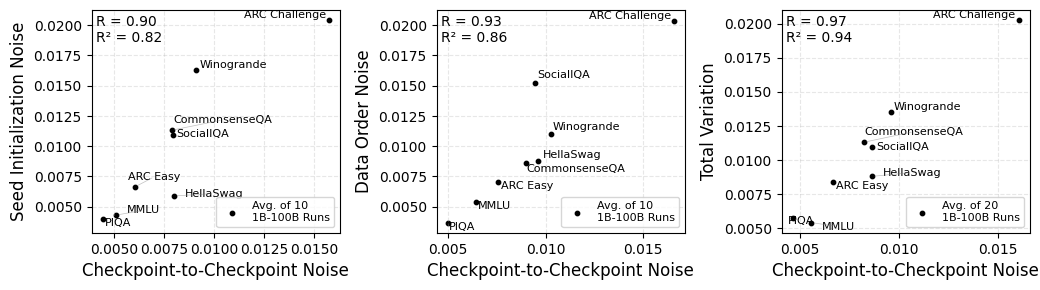

In [20]:
from plot import adjustText

CLEAN_LABEL_MAP = {
    'eval/downstream/arc_easy_test_rc_5shot (length-normalized accuracy)': 'ARC Easy',
    'eval/downstream/csqa_val_rc_5shot (length-normalized accuracy)': 'CommonsenseQA',
    'eval/downstream/socialiqa_val_rc_5shot (length-normalized accuracy)': 'SocialIQA', 
    'eval/downstream/hellaswag_rc_5shot (length-normalized accuracy)': 'HellaSwag',
    'eval/downstream/arc_challenge_test_rc_5shot (length-normalized accuracy)': 'ARC Challenge',
    'eval/downstream/winogrande_val_rc_5shot (length-normalized accuracy)': 'Winogrande',
    'eval/downstream/piqa_val_rc_5shot (length-normalized accuracy)': 'PIQA',
    'eval/downstream/mmlu_test_rc_5shot (length-normalized accuracy)': 'MMLU'
}

metric_names = df_in_loop['metric_name'].unique()
metric_names = [m for m in metric_names if "_mc_" not in m]
metric_names = [m for m in metric_names if not ('mmlu' in m and '_val_' in m)]
metric_names = [m for m in metric_names if 'copycolors' not in m]
# metric_names = [m for m in metric_names if 'log soft loss' not in m]
# metric_names = [m for m in metric_names if 'soft loss' not in m]
# metric_names = [m for m in metric_names if 'CE loss' not in m]
metric_names = [m for m in metric_names if 'accuracy' in m]
metric_names = [m for m in metric_names if m not in [
    "eval/downstream/mmlu_other_test_rc_5shot (length-normalized accuracy)",
    "eval/downstream/mmlu_social_sciences_test_rc_5shot (length-normalized accuracy)",
    "eval/downstream/mmlu_stem_test_rc_5shot (length-normalized accuracy)",
    "eval/downstream/mmlu_humanities_test_rc_5shot (length-normalized accuracy)"
]]
metric_names = [m for m in metric_names if 'boolq' not in m and 'openbookqa' not in m]

ALL_METRIC_NAMES = metric_names

n_rows = 3
# fig, axes = plt.subplots(n_rows, 1, figsize=(3.75, 2.75*n_rows))
fig, axes = plt.subplots(1, n_rows, figsize=(3.5*n_rows, 3))

for i, run_type in enumerate(['seed', 'data', 'tv']):
    if run_type == 'tv':
        _in_loop = df_in_loop.copy()
    else:
        _in_loop = df_in_loop[df_in_loop['run_type'] == run_type].copy()

    variations = []
    final_stds = []
    metric_labels = []
    for metric_name in metric_names:
        metric_data = _in_loop[_in_loop['metric_name'] == metric_name]

        # Compute relative standard deviation of last 20 checkpoints
        total_var = 0
        n_seeds = 0
        for run_name in metric_data['run_name'].unique():
            run_data = metric_data[metric_data['run_name'] == run_name]
            values = run_data['value'].values[-20:]  # Get last 20 checkpoints
            rel_std = np.std(values) / np.mean(values)  # Calculate relative std dev
            total_var += rel_std
            n_seeds += 1
        avg_variation = total_var / n_seeds
        variations.append(avg_variation)
        
        if run_type == 'tv':
            all_total_var = 0
            n_seeds = 0
            for run_name in metric_data['run_name'].unique():
                run_data = metric_data[metric_data['run_name'] == run_name]
                values = run_data['value'].values  # Get full training curve
                from stats import calc_total_variation
                
                total_var = calc_total_variation(values, improvement=True) / np.mean(values)  # Calculate relative std dev
                
                all_total_var += total_var
                n_seeds += 1
            avg_variation = all_total_var / n_seeds
            final_stds.append(avg_variation)
        else:
            # Calculate seed/data order noise
            final_scores = []
            for run_name in metric_data['run_name'].unique():
                run_data = metric_data[metric_data['run_name'] == run_name]
                final_scores.append(run_data['value'].iloc[-5:].mean())
            rel_std = np.std(final_scores) / np.mean(final_scores)
            final_stds.append(rel_std)
        
        clean_name = metric_name.replace('eval/downstream/', '').replace(' (length-normalized accuracy)', '')
        metric_labels.append(CLEAN_LABEL_MAP.get(metric_name, clean_name))

    ax = axes[i]
    ax.scatter(variations, final_stds, color='black', s=10, marker='o')

    # Calculate and add R and R^2 values
    r = np.corrcoef(variations, final_stds)[0,1]
    r2 = r**2
    ax.text(0.02, 0.98, f'R = {r:.2f}\nR² = {r2:.2f}', 
            transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=10)

    texts = []
    for i, label in enumerate(metric_labels):
        texts.append(ax.text(variations[i], final_stds[i], label, fontsize=8))
    adjustText(ax, texts)

    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xlabel('Checkpoint-to-Checkpoint Noise', fontsize=12)
    ax.legend([ax.scatter([], [], color='black', marker='o', s=10)], [f'Avg. of {"20" if run_type == "tv" else "10"}\n1B-100B Runs'], fontsize=8, loc='lower right')

# Share y-axis between subplots
axes[0].set_ylabel('Seed Initialization Noise', fontsize=12)
axes[1].set_ylabel('Data Order Noise', fontsize=12)
axes[2].set_ylabel('Total Variation', fontsize=12)

y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/seed_vs_step_noise.pdf', bbox_inches='tight', pad_inches=0.25)
plt.show()

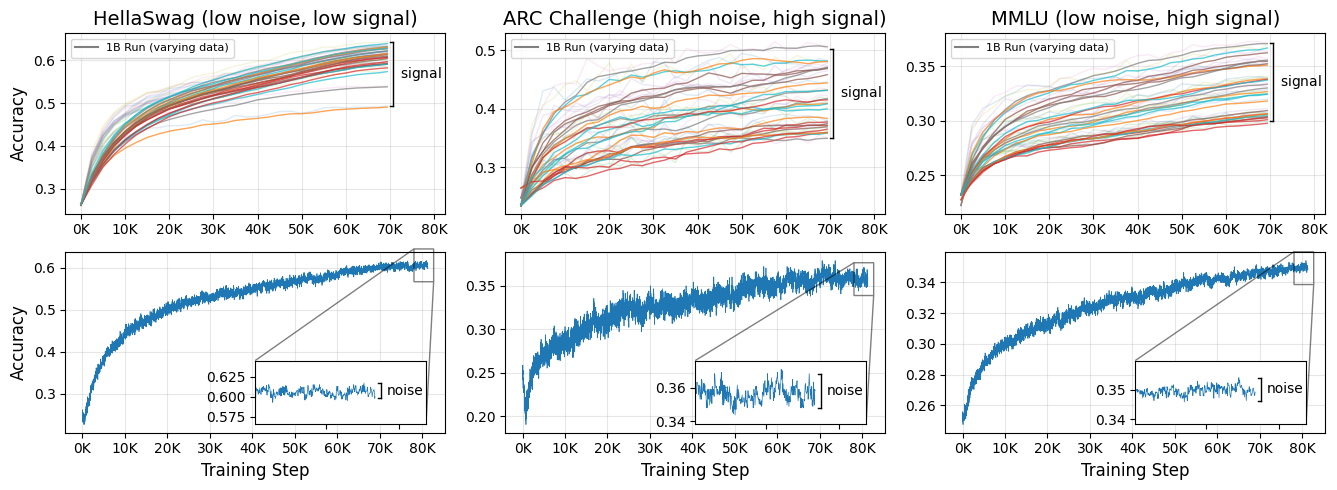

In [21]:
from utils import PLOT_DIR
from plot import setup_plot_grid, plot_random_seeds, plot_single_run, plot_datasets, format_axes

metric_names = [
    'eval/downstream/hellaswag_rc_5shot (length-normalized accuracy)',
    'eval/downstream/arc_challenge_test_rc_5shot (length-normalized accuracy)',
    'eval/downstream/mmlu_test_rc_5shot (length-normalized accuracy)', 
]
plotted_tasks = ['hellaswag', 'arc_challenge', 'mmlu']
task_labels   = ['HellaSwag (low noise, low signal)', 'ARC Challenge (high noise, high signal)', 'MMLU (low noise, high signal)']

seed_in_loop = df_in_loop[df_in_loop['run_type'] == 'high-eval'].copy()

num_rows = 2
num_cols = len(plotted_tasks)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4.5*num_cols, 2.5*num_rows))
axes = axes.flatten()

for i, (metric_name, plotted_task, task_label) in enumerate(zip(metric_names, plotted_tasks, task_labels)):
    if i < len(task_labels): 
        axes[i].set_title(task_label, fontsize=14)

    metric_data = seed_in_loop[seed_in_loop['metric_name'] == metric_name]
    
    plot_datasets(axes[i], plotted_task, metric, MIXES, SEED, df)
    plot_single_run(axes[3 + i], metric_data, task_label)

format_axes(axes)
for idx in range(3 + len(metric_names) + len(plotted_tasks), len(axes)):
    axes[idx].set_visible(False)

axes[0].set_ylabel('Accuracy', fontsize=12)
axes[3].set_ylabel('Accuracy', fontsize=12)

axes[3].set_xlabel('Training Step', fontsize=12)
axes[4].set_xlabel('Training Step', fontsize=12)
axes[5].set_xlabel('Training Step', fontsize=12)

plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/noise_example.pdf", dpi=300, bbox_inches='tight')
plt.show()

<>:76: SyntaxWarning: invalid escape sequence '\%'
<>:76: SyntaxWarning: invalid escape sequence '\%'
/var/folders/cr/z51hvhb932vbx29jw5hxd9nh0000gn/T/ipykernel_81812/4236787185.py:76: SyntaxWarning: invalid escape sequence '\%'
  ax.annotate(f'Decision accuracy from\n150M to 1B = $\\mathbf{{{rank_agreement*100:.1f}}}\%$',


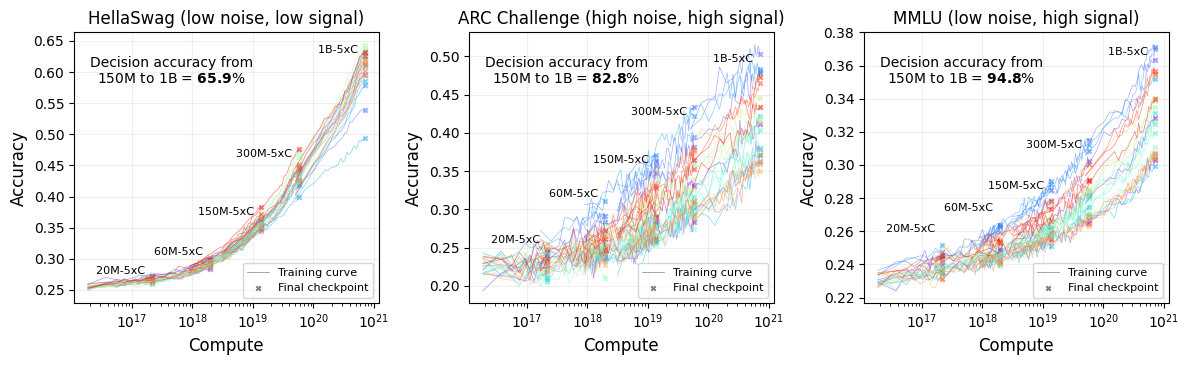

In [22]:
from dataloader import get_slice
from utils import PLOT_DIR
from scipy.stats import spearmanr

# task_labels   = ['HellaSwag (low noise, low signal)', 'OpenBookQA (high noise, high signal)', 'MMLU (low noise, high signal)']
# plotted_tasks = ['hellaswag', 'openbookqa', 'mmlu']
task_labels   = ['HellaSwag (low noise, low signal)', 'ARC Challenge (high noise, high signal)', 'MMLU (low noise, high signal)']
plotted_tasks = ['hellaswag', 'arc_challenge', 'mmlu']
plotted_sizes = ['20M', '60M', '150M', '300M', '1B']
plotted_mixes = MIXES
metric = 'primary_metric'

colors = plt.cm.rainbow(np.linspace(0, 1, len(plotted_mixes)))

num_rows = (len(plotted_tasks) + 3) // 4 
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 3.75*num_rows)) # 3.5
axes = axes.flatten() 

lines = [] 
labels = []
for task_idx, task in enumerate(plotted_tasks):
    ax: plt.Axes = axes[task_idx]
    
    # Track best final performance for each size
    size_best_perf = {size: {'value': float('-inf'), 'x': None, 'y': None} for size in plotted_sizes}
    final_values_150M = []
    final_values_1B   = []
    for mix_idx, mix in enumerate(plotted_mixes):
        for size in plotted_sizes:
            curve_data = get_slice(df, mix=mix, task=task, size=size, seed=SEED)

            # Remove first X% of rows
            curve_data = curve_data[curve_data['compute'] > 0].sort_values('compute') # remove compute=0
            curve_data = curve_data.iloc[int(0.05*len(curve_data)):]
        
            line = ax.plot(
                curve_data['compute'], curve_data[metric], linewidth=0.5, 
                color=colors[mix_idx], alpha=0.5
            )
            ax.scatter(
                curve_data['compute'].iloc[-1], curve_data[metric].iloc[-1], 
                color=colors[mix_idx], alpha=0.5, s=10, marker='x'
            )
            
            # Keep final values for rank correlation
            if size == '150M':
                final_values_150M.append((mix, curve_data[metric].iloc[-1]))
            elif size == '1B':
                final_values_1B.append((mix, curve_data[metric].iloc[-1]))
            
            # Keep track of best performing mix
            final_value = curve_data[metric].iloc[-1]
            if final_value > size_best_perf[size]['value']:
                size_best_perf[size]['value'] = final_value
                size_best_perf[size]['x'] = curve_data['compute'].iloc[-1]
                size_best_perf[size]['y'] = final_value
        
        if task_idx == 0:
            lines.extend(line)
            labels.append(f'{mix}')

    # Add size annotations
    for size, perf in size_best_perf.items():
        if perf['x'] is not None:
            y_offset = perf['y'] * 0.05 if size in ['20M', '60M'] else 0
            ax.annotate(f'{size}-5xC  ', (perf['x'], perf['y'] + y_offset),
                        xytext=(0, 0), textcoords='offset points', fontsize=8, ha='right', va='top')

    # Calculate rank correlation between 150M and 1B
    sorted_150M = sorted(final_values_150M, key=lambda x: x[1])
    sorted_1B   = sorted(final_values_1B, key=lambda x: x[1])
    rank_150M   = {mix: i for i, (mix, _) in enumerate(sorted_150M)}
    rank_1B     = {mix: i for i, (mix, _) in enumerate(sorted_1B)}
    rank_agreement = spearmanr([rank_150M[mix] for mix, _ in sorted_150M], 
                               [rank_1B[mix] for mix, _ in sorted_150M])[0]
    ax.annotate(f'Decision accuracy from\n150M to 1B = $\\mathbf{{{rank_agreement*100:.1f}}}\%$',
                xy=(0.32, 0.8), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')

    ax.set_xscale('log')
    ax.set_title(task_labels[task_idx], fontsize=12)
    ax.set_xlabel('Compute', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    dummy_line = ax.plot([], [], color='grey', linewidth=0.5, label='Training curve')
    dummy_point = ax.scatter([], [], color='grey', s=10, marker='x', label='Final checkpoint')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.2)

for idx in range(task_idx + 1, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/decision_accuracy_example.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

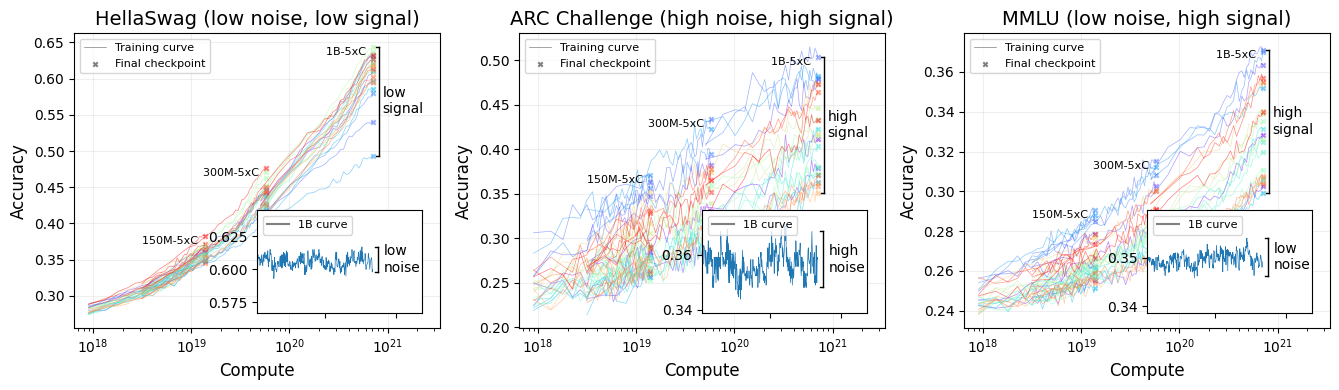

In [23]:
from utils import PLOT_DIR
from plot import setup_plot_grid, plot_random_seeds, plot_single_run, plot_datasets, format_axes

metric_names = [
    'eval/downstream/hellaswag_rc_5shot (length-normalized accuracy)',
    'eval/downstream/arc_challenge_test_rc_5shot (length-normalized accuracy)',
    'eval/downstream/mmlu_test_rc_5shot (length-normalized accuracy)', 
]
plotted_tasks = ['hellaswag', 'arc_challenge', 'mmlu']
task_labels   = ['HellaSwag (low noise, low signal)', 'ARC Challenge (high noise, high signal)', 'MMLU (low noise, high signal)']
noise_label   = ['low\nnoise', 'high\nnoise', 'low\nnoise']
signal_label  = ['low\nsignal', 'high\nsignal', 'high\nsignal']

seed_in_loop = df_in_loop[df_in_loop['run_type'] == 'high-eval'].copy()

num_rows = 1 # 3
num_cols = len(plotted_tasks)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4.5*num_cols, 4*num_rows))
axes = axes.flatten()

for i, (metric_name, plotted_task, task_label) in enumerate(zip(metric_names, plotted_tasks, task_labels)):
    if i < len(task_labels): 
        axes[i].set_title(task_label, fontsize=14)

    metric_data = seed_in_loop[seed_in_loop['metric_name'] == metric_name]
    
    # plot_datasets(axes[i], plotted_task, metric, MIXES, SEED, df)
    # plot_single_run(axes[3 + i], metric_data, task_label)

    plot_single_run(axes[i], metric_data, task_label, noise_label=noise_label[i], inset_only=True)

format_axes(axes)
# for idx in range(3 + len(metric_names) + len(plotted_tasks), len(axes)):
#     axes[idx].set_visible(False)

axes[0].set_ylabel('Accuracy', fontsize=12)
# axes[3].set_ylabel('Accuracy', fontsize=12)

# axes[3].set_xlabel('Training Step', fontsize=12)
# axes[4].set_xlabel('Training Step', fontsize=12)
# axes[5].set_xlabel('Training Step', fontsize=12)

from dataloader import get_slice
from utils import PLOT_DIR
from scipy.stats import spearmanr

# task_labels   = ['HellaSwag (low noise, low signal)', 'OpenBookQA (high noise, high signal)', 'MMLU (low noise, high signal)']
# plotted_tasks = ['hellaswag', 'openbookqa', 'mmlu']
task_labels   = ['HellaSwag (low noise, low signal)', 'ARC Challenge (high noise, high signal)', 'MMLU (low noise, high signal)']
plotted_tasks = ['hellaswag', 'arc_challenge', 'mmlu']
# plotted_sizes = ['20M', '60M', '150M', '300M', '1B']
plotted_sizes = ['150M', '300M', '1B']
plotted_mixes = MIXES
metric = 'primary_metric'

colors = plt.cm.rainbow(np.linspace(0, 1, len(plotted_mixes)))

lines = [] 
labels = []
for task_idx, task in enumerate(plotted_tasks):
    # ax: plt.Axes = axes[6+task_idx]
    ax: plt.Axes = axes[task_idx]
    
    # Track best final performance for each size
    size_best_perf = {size: {'value': float('-inf'), 'x': None, 'y': None} for size in plotted_sizes}
    final_values_150M = []
    final_values_1B   = []
    for mix_idx, mix in enumerate(plotted_mixes):
        for size in plotted_sizes:
            curve_data = get_slice(df, mix=mix, task=task, size=size, seed=SEED)

            # Remove first X% of rows
            curve_data = curve_data[curve_data['compute'] > 0].sort_values('compute') # remove compute=0
            curve_data = curve_data.iloc[int(0.05*len(curve_data)):]
        
            line = ax.plot(
                curve_data['compute'], curve_data[metric], linewidth=0.5, 
                color=colors[mix_idx], alpha=0.5
            )
            ax.scatter(
                curve_data['compute'].iloc[-1], curve_data[metric].iloc[-1], 
                color=colors[mix_idx], alpha=0.5, s=10, marker='x'
            )
            
            # Keep final values for rank correlation
            if size == '150M':
                final_values_150M.append((mix, curve_data[metric].iloc[-1]))
            elif size == '1B':
                final_values_1B.append((mix, curve_data[metric].iloc[-1]))
            
            # Keep track of best performing mix
            final_value = curve_data[metric].iloc[-1]
            if final_value > size_best_perf[size]['value']:
                size_best_perf[size]['value'] = final_value
                size_best_perf[size]['x'] = curve_data['compute'].iloc[-1]
                size_best_perf[size]['y'] = final_value
        
        if task_idx == 0:
            lines.extend(line)
            labels.append(f'{mix}')

    # Add size annotations
    for size, perf in size_best_perf.items():
        if perf['x'] is not None:
            y_offset = perf['y'] * 0.05 if size in ['20M', '60M'] else 0
            ax.annotate(f'{size}-5xC  ', (perf['x'], perf['y'] + y_offset),
                        xytext=(0, 0), textcoords='offset points', fontsize=8, ha='right', va='top')

    # Calculate rank correlation between 150M and 1B
    sorted_150M = sorted(final_values_150M, key=lambda x: x[1])
    sorted_1B   = sorted(final_values_1B, key=lambda x: x[1])
    rank_150M   = {mix: i for i, (mix, _) in enumerate(sorted_150M)}
    rank_1B     = {mix: i for i, (mix, _) in enumerate(sorted_1B)}
    rank_agreement = spearmanr([rank_150M[mix] for mix, _ in sorted_150M], 
                               [rank_1B[mix] for mix, _ in sorted_150M])[0]
    # ax.annotate(f'Decision accuracy from\n150M to 1B = $\\mathbf{{{rank_agreement*100:.1f}}}\%$',
    #             xy=(0.25, 0.72), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')

    ############
    # Add bracket
    ############
    max_compute = curve_data['compute'].iloc[-1]
    values = [score for (mix, score) in final_values_1B]
    y_min = min(values)
    y_max = max(values)
        
    y_mid = (y_min + y_max) / 2

    x_pos = max_compute * 1.15
    bracket_width = x_pos * 0.05
    text_spacing = bracket_width

    ax.plot([x_pos, x_pos], [y_min, y_max], color='black', linewidth=1)
    ax.plot([x_pos, x_pos - bracket_width], [y_min, y_min], color='black', linewidth=1)
    ax.plot([x_pos, x_pos - bracket_width], [y_max, y_max], color='black', linewidth=1)
    
    ax.annotate(signal_label[task_idx],
                xy=(x_pos + text_spacing, y_mid),
                xytext=(x_pos + text_spacing * 2, y_mid),
                ha='left', va='center')
    ############


    ax.set_xscale('log')
    # ax.set_title(task_labels[task_idx], fontsize=12)
    ax.set_xlabel('Compute', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    
    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0], xlim[1]*3)

    dummy_line = ax.plot([], [], color='grey', linewidth=0.5, label='Training curve')
    dummy_point = ax.scatter([], [], color='grey', s=10, marker='x', label='Final checkpoint')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.2)

# Remove spacing between first and second row
plt.subplots_adjust(hspace=0)

# for idx in range(task_idx + 1, len(axes)):
#     axes[idx].set_visible(False)

# Add legend to inset axis
for ax in axes.flatten():
    # Get the inset axis
    inset_axes = [child for child in ax.get_children() if isinstance(child, plt.Axes)]
    if inset_axes:
        inset_ax = inset_axes[0]
        # Add legend to inset
        inset_ax.legend([inset_ax.plot([], [], color='grey')[0]], [f'1B curve'], loc='upper left', fontsize=8)


plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/signal_noise_error.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# Largest step difference for ARC-Challenge
final_30 = seed_in_loop[seed_in_loop['metric_name'] == 'eval/downstream/arc_challenge_test_rc_5shot (length-normalized accuracy)'].tail(40)
max_row = final_30.loc[final_30['value'].idxmax()]
min_row = final_30.loc[final_30['value'].idxmin()]
print(f"Max: step={max_row['step']}, value={max_row['value']}")
print(f"Min: step={min_row['step']}, value={min_row['value']}")

diff_val = max_row['value'] - min_row['value']
diff_step = max_row['step'] - min_row['step']
print(f"Value difference: {diff_val}")
print(f"Step difference: {diff_step}")

Max: step=81180, value=0.3686006963253021
Min: step=80950, value=0.3481228649616241
Value difference: 0.020477831363678034
Step difference: 230


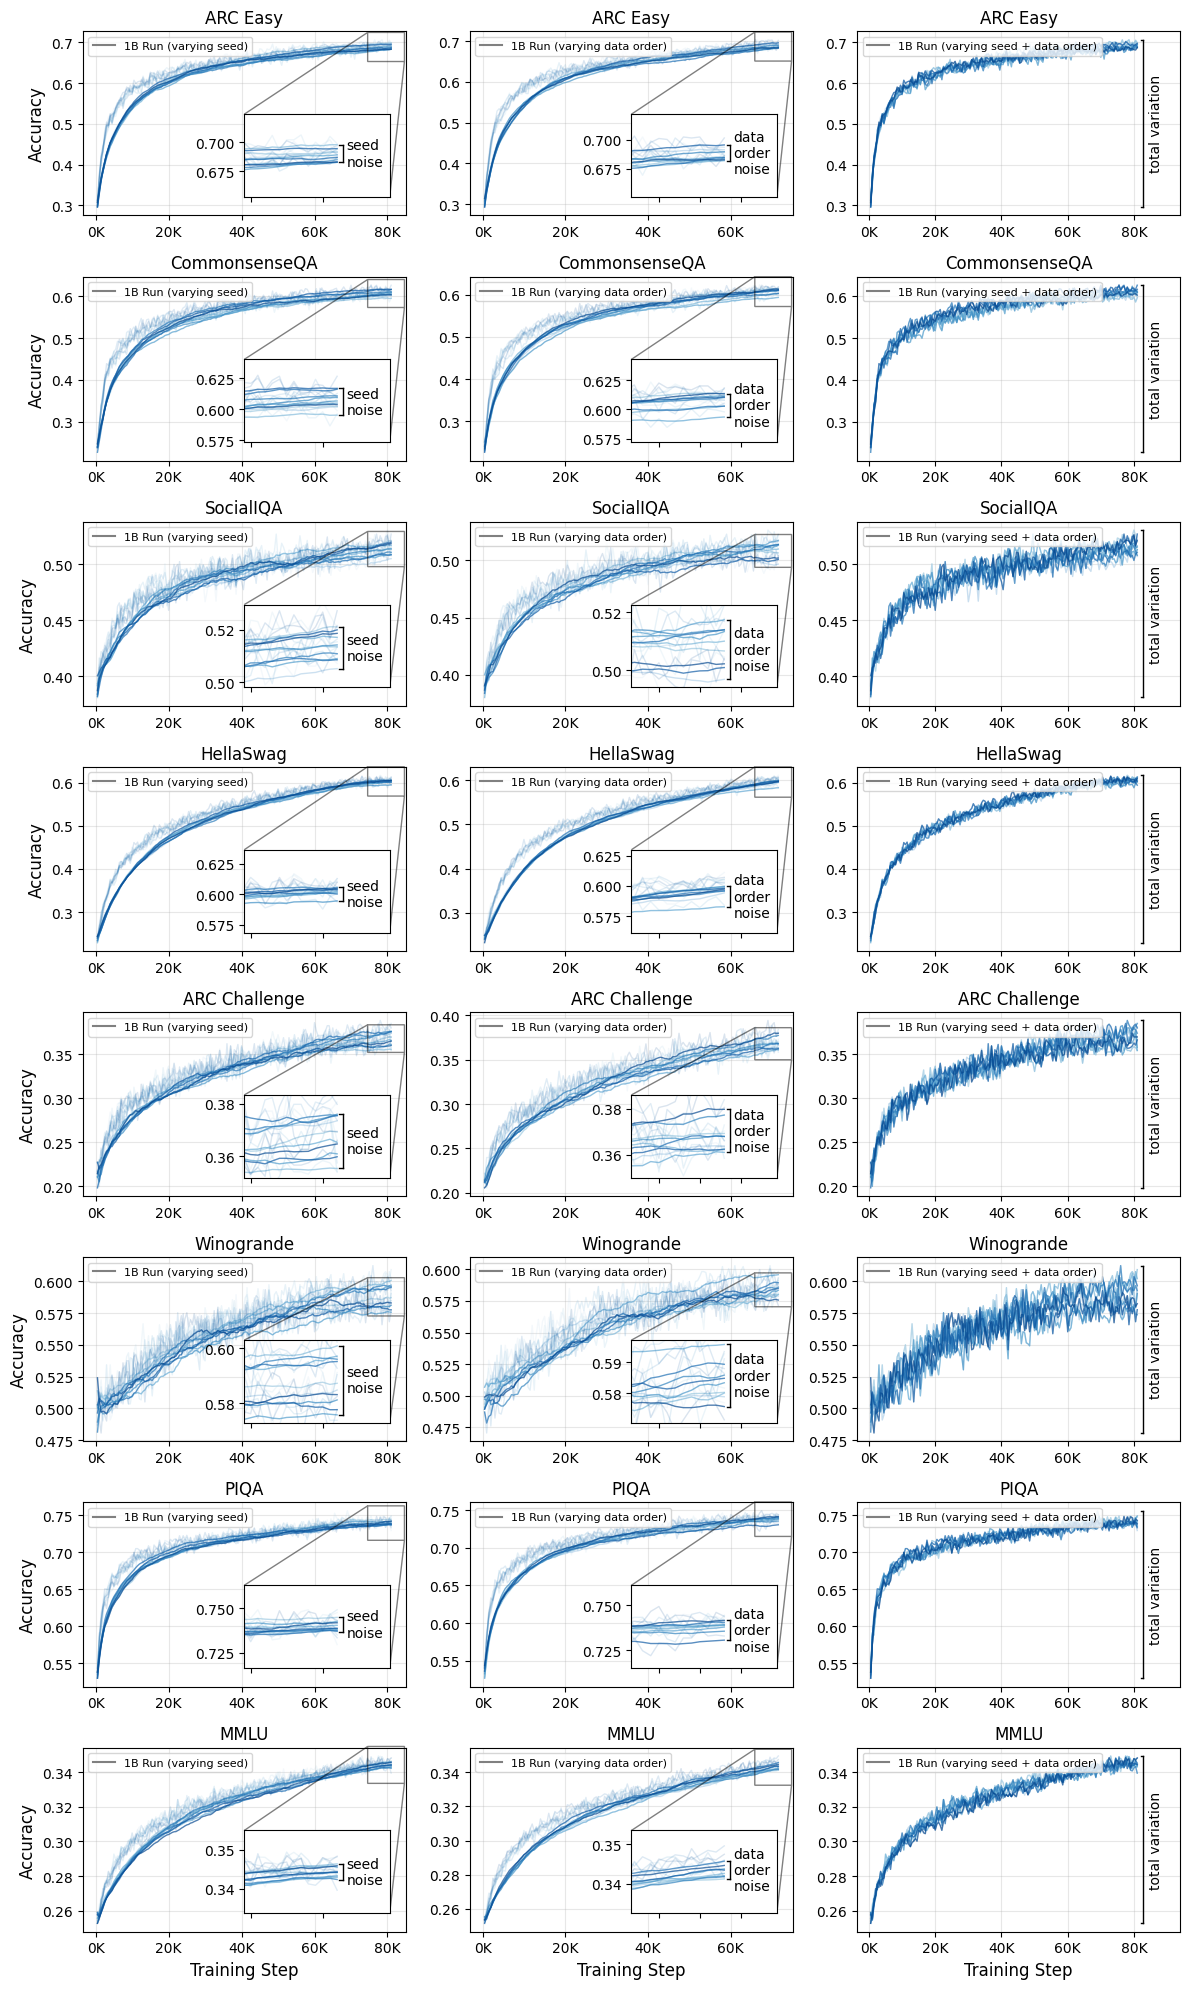

In [25]:
from utils import PLOT_DIR
from plot import setup_plot_grid, plot_random_seeds, plot_single_run, plot_datasets, format_axes

metric_names = [
    'eval/downstream/hellaswag_rc_5shot (length-normalized accuracy)',
    'eval/downstream/arc_challenge_test_rc_5shot (length-normalized accuracy)',
    'eval/downstream/mmlu_test_rc_5shot (length-normalized accuracy)', 
]
plotted_tasks = ['hellaswag', 'arc_challenge', 'mmlu']

metric_names = ALL_METRIC_NAMES
plotted_tasks = ALL_METRIC_NAMES

data_in_loop = df_in_loop[df_in_loop['run_type'] == 'data'].copy()
seed_in_loop = df_in_loop[df_in_loop['run_type'] == 'seed'].copy()

num_rows = 3
num_cols = len(plotted_tasks)

fig, axes = plt.subplots(num_cols, num_rows, figsize=(4*num_rows, 2.5*num_cols)) # 3
axes = axes.T

if num_cols == 1:
    axes = np.array([[ax] for ax in axes])

for i, (metric_name, plotted_task) in enumerate(zip(metric_names, plotted_tasks)):
    task_label = CLEAN_LABEL_MAP.get(metric_name, metric_name)

    axes[0, i].set_title(task_label)
    axes[1, i].set_title(task_label)
    axes[2, i].set_title(task_label)

    data_data = data_in_loop[data_in_loop['metric_name'] == metric_name]
    seed_data = seed_in_loop[seed_in_loop['metric_name'] == metric_name]
    
    plot_random_seeds(axes[0, i], seed_data, label='seed', inset_legend=False)
    plot_random_seeds(axes[1, i], data_data, label='data order', inset_legend=False)
    plot_random_seeds(axes[2, i], seed_data, label='total variation', plot_inset=False, emw_width=1, inset_legend=False)

    if i == len(plotted_tasks) - 1:
        axes[0, i].set_xlabel('Training Step', fontsize=12)
        axes[1, i].set_xlabel('Training Step', fontsize=12)
        axes[2, i].set_xlabel('Training Step', fontsize=12)

    axes[0, i].set_ylabel('Accuracy', fontsize=12)

format_axes(axes)
for idx in range(3 + len(metric_names) + len(plotted_tasks), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
# plt.savefig(f"{PLOT_DIR}/seed_noise_example.pdf", dpi=300, bbox_inches='tight')
plt.savefig(f"{PLOT_DIR}/seed_noise_example_large.pdf", dpi=300, bbox_inches='tight')
plt.show()

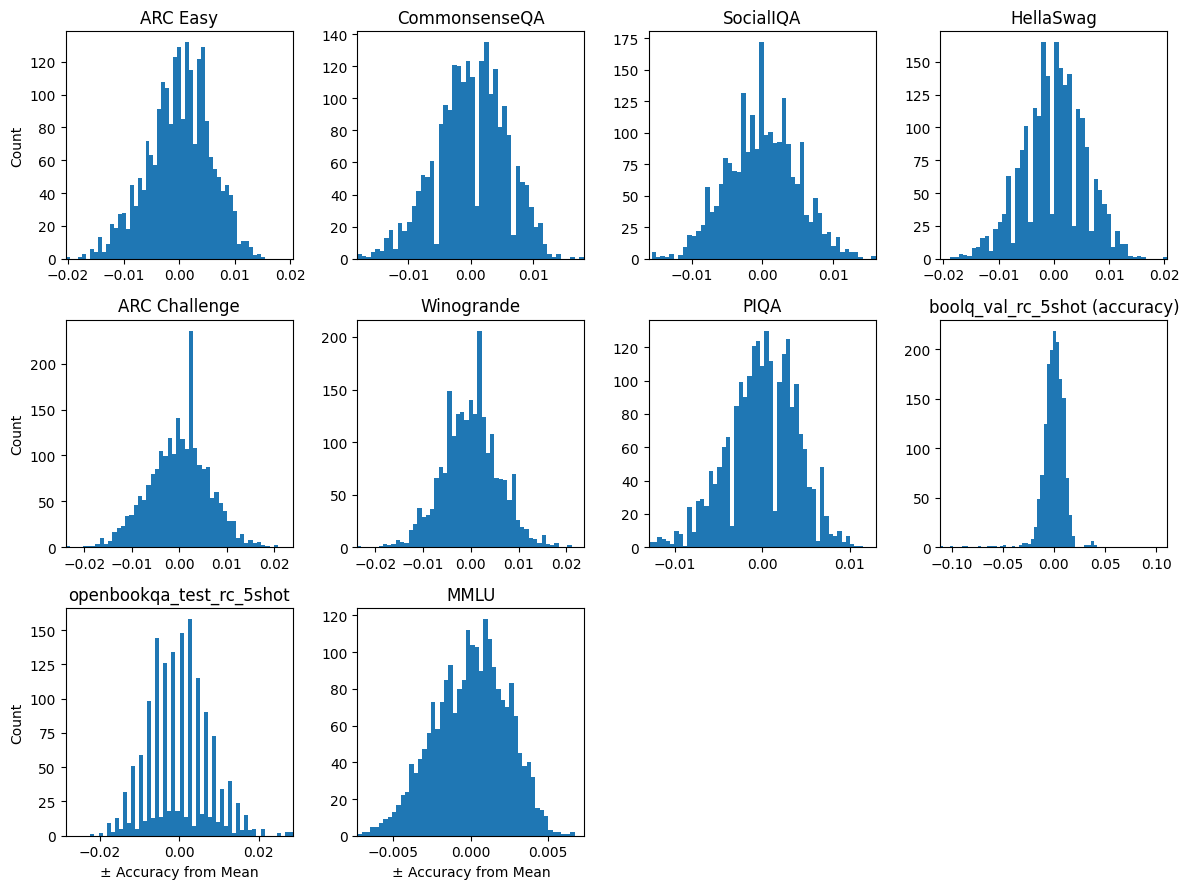

In [26]:
# Plot distribution of step-to-step noise
metric_names = df_in_loop['metric_name'].unique()
metric_names = [m for m in metric_names if "_mc_" not in m]
metric_names = [m for m in metric_names if not ('mmlu' in m and '_val_' in m)]
metric_names = [m for m in metric_names if 'copycolors' not in m]
metric_names = [m for m in metric_names if 'accuracy' in m]
metric_names = [m for m in metric_names if m not in [
    "eval/downstream/mmlu_other_test_rc_5shot (length-normalized accuracy)",
    "eval/downstream/mmlu_social_sciences_test_rc_5shot (length-normalized accuracy)",
    "eval/downstream/mmlu_stem_test_rc_5shot (length-normalized accuracy)",
    "eval/downstream/mmlu_humanities_test_rc_5shot (length-normalized accuracy)"
]]

variations = []
for metric_name in metric_names:
    metric_data = df_in_loop[df_in_loop['metric_name'] == metric_name]
    values = []
    
    # Collect values for each run
    for run_name in metric_data['run_name'].unique():
        run_data = metric_data[metric_data['run_name'] == run_name]
        run_values = run_data['value'].values
        
        # Get last 20% of values and normalize
        last_values = run_values[int(-0.2 * len(run_values)):]
        normalized_values = last_values - np.mean(last_values)
        values.extend(normalized_values)
        
    variations.append(values)

# Plot histograms
n_metrics = len(metric_names)
n_cols = 4
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, 3*n_rows))
axes = axes.flatten()
for i, (metric_name, values) in enumerate(zip(metric_names, variations)):
    ax: plt.Axes = axes[i]
    
    x_bound = max(abs(min(values)), abs(max(values)))
    clean_name = metric_name.replace('eval/downstream/', '').replace(' (length-normalized accuracy)', '')
    clean_name = CLEAN_LABEL_MAP.get(metric_name, clean_name)

    ax.hist(values, bins=50)
    ax.set_title(clean_name)
    ax.set_xlim(-x_bound, x_bound)
    if i >= len(axes) - n_cols:
        ax.set_xlabel('± Accuracy from Mean')
    if i % n_cols == 0:
        ax.set_ylabel('Count')

for ax in axes[len(variations):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

### Decision Accuracy Scores Considering Adjacent Ckpts

100%|██████████| 11/11 [01:42<00:00,  9.33s/it]


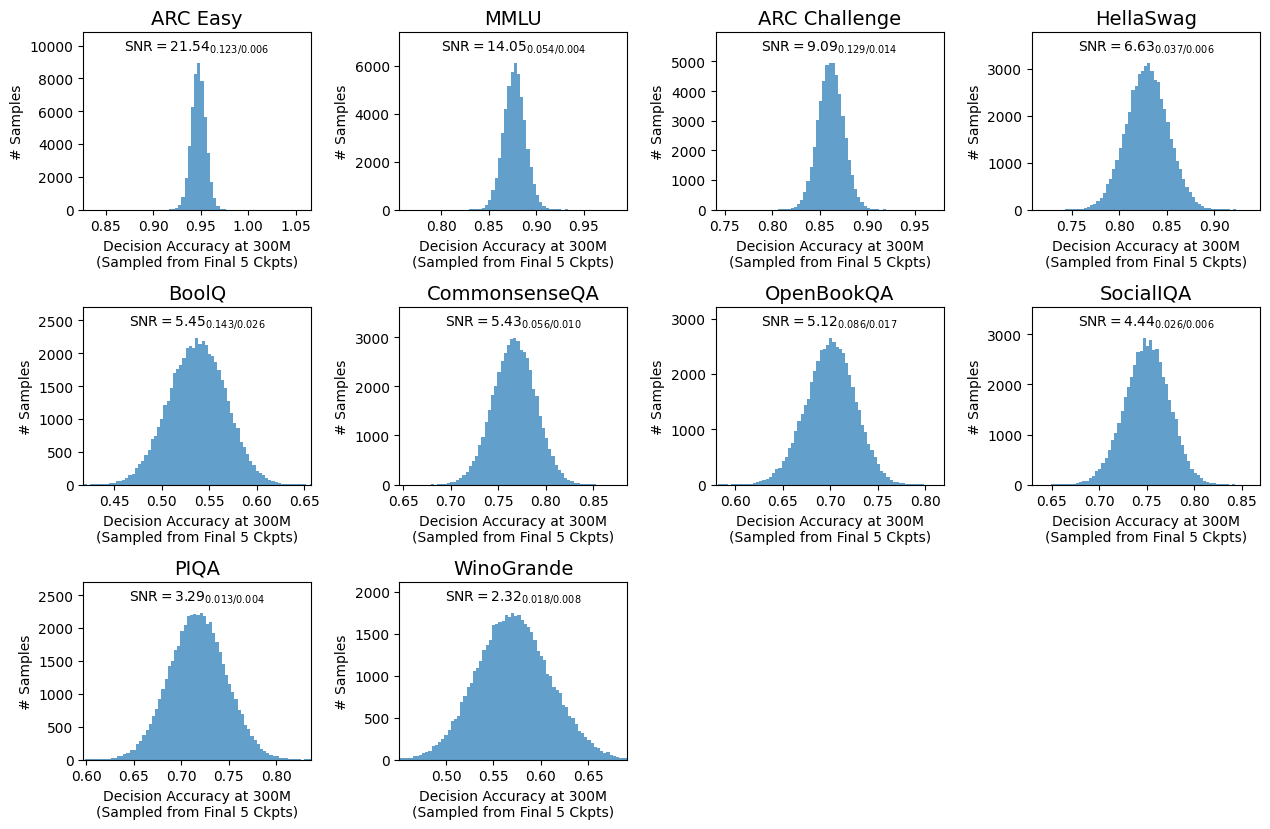

In [27]:
from dataloader import get_slice
import numpy as np
import pandas as pd

from utils import get_pretty_task_name

size = '300M'
seed = 6198

def get_last_n(group_data):
    sorted_data = group_data.sort_values('compute')
    last_n_entries = sorted_data.iloc[int(-0.2 * len(group_data)):]
    # print(int(-0.2 * len(group_data)))
    return last_n_entries[metric].values

def decision_acc(scores_small, scores_target):
    scores_small = np.array(scores_small)
    scores_target = np.array(scores_target)
    small_diffs = scores_small[:, np.newaxis] > scores_small[np.newaxis, :]
    target_diffs = scores_target[:, np.newaxis] > scores_target[np.newaxis, :]
    mask = np.triu(np.ones_like(small_diffs), k=1).astype(bool)
    agreements = (small_diffs == target_diffs)[mask]
    return np.mean(agreements)

all_trial_accuracies = []
all_avg_accuracies = []
task_names = []
rel_std_small_ckpts = []  # Relative std across checkpoints for small models
rel_std_1b_ckpts = []    # Relative std across checkpoints for 1B models
rel_std_small_mixes = [] # Relative std across mixes for small models
rel_std_1b_mixes = []   # Relative std across mixes for 1B models

for task in tqdm(selected_tasks):
# for task in tqdm(['winogrande', 'csqa', 'mmlu', 'arc_easy']):
    if 'olmes' in task: continue # skip macro-average

    curve_data    = get_slice(df, task=task, seed=seed, size=size)
    curve_data_1b = get_slice(df, task=task, seed=seed, size="1B")
    if curve_data.empty: continue

    # Get unique mixes from both curve_data and curve_data_1b
    mixes = curve_data['group'].unique()
    mixes_1b = curve_data_1b['group'].unique()

    # Get last N entries for each mix
    last_checkpoints = curve_data.groupby('group').apply(get_last_n, include_groups=False).reset_index()
    last_checkpoints.columns = ['group', 'values']
    last_checkpoints_1b = curve_data_1b.groupby('group').apply(get_last_n, include_groups=False).reset_index()
    last_checkpoints_1b.columns = ['group', 'values']

    # Calculate relative std across last checkpoints
    rel_std_small = np.mean([np.std(vals)/np.mean(vals) for vals in last_checkpoints['values']])
    rel_std_1b = np.mean([np.std(vals)/np.mean(vals) for vals in last_checkpoints_1b['values']])
    rel_std_small_ckpts.append(rel_std_small)
    rel_std_1b_ckpts.append(rel_std_1b)

    # Calculate relative std across mixes (using last checkpoint)
    last_ckpt_small = [vals[-1] for vals in last_checkpoints['values']]
    last_ckpt_1b = [vals[-1] for vals in last_checkpoints_1b['values']]
    rel_std_small_mixes.append(np.std(last_ckpt_small)/np.mean(last_ckpt_small))
    rel_std_1b_mixes.append(np.std(last_ckpt_1b)/np.mean(last_ckpt_1b))

    last_checkpoints = last_checkpoints.rename(columns={'group': 'mix'})
    last_checkpoints_1b = last_checkpoints_1b.rename(columns={'group': 'mix'})
    
    # For each trial, sample one value per mix and compute decision accuracy
    # n_trials = 500
    n_trials = 50_000
    trial_accuracies = []
    
    for _ in range(n_trials):
        # Sample one value per mix for both sizes
        sampled_scores_small = np.array([np.random.choice(values) for values in last_checkpoints['values']])
        sampled_scores_1b = np.array([np.random.choice(values) for values in last_checkpoints_1b['values']])
        
        # Compute decision accuracy between sampled values
        acc = decision_acc(sampled_scores_small, sampled_scores_1b)
        trial_accuracies.append(acc)

    # Compute average
    avg_scores_small = np.array([np.mean(values) for values in last_checkpoints['values']])
    avg_scores_1b = np.array([np.mean(values) for values in last_checkpoints_1b['values']])
    avg_acc = decision_acc(avg_scores_small, avg_scores_1b)
    
    all_trial_accuracies.append(trial_accuracies)
    all_avg_accuracies.append(avg_acc)
    task_names.append(task)

# Plot distributions for all tasks in separate subfigures
n_tasks = len(task_names)
n_cols = min(n_tasks, 4)
n_rows = (n_tasks + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=((16/5)*n_cols, 2.8*n_rows))
axes = axes.flatten()

# DELTA = 0.07
DELTA = 0.12

# Calculate SNR for each task and sort
snr_values = [(signal/noise, i) for i, (signal, noise) in enumerate(zip(rel_std_small_mixes, rel_std_small_ckpts))]
sorted_indices = [i for _, i in sorted(snr_values, reverse=True)]

# Plot in sorted order
for plot_idx, data_idx in enumerate(sorted_indices):
    accuracies = all_trial_accuracies[data_idx]
    avg_acc = all_avg_accuracies[data_idx] 
    task = task_names[data_idx]
    
    mean_acc = np.mean(accuracies)
    bins = np.linspace(0, 1, 300)
    axes[plot_idx].hist(accuracies, bins=bins, alpha=0.7)
    axes[plot_idx].set_xlabel('Decision Accuracy at 300M\n(Sampled from Final 5 Ckpts)', fontsize=10)
    axes[plot_idx].set_ylabel('# Samples')
    axes[plot_idx].set_title(get_pretty_task_name(task), fontsize=14)
    axes[plot_idx].set_xlim(mean_acc - DELTA, mean_acc + DELTA)

    signal = rel_std_small_mixes[data_idx].item()
    noise = rel_std_small_ckpts[data_idx].item()
    avg_rel_std_text = (
        r'$\text{SNR}=' + f'{(signal/noise):.2f}' + r'_{' + f'{signal:.3f} ' + r' / ' + f' {noise:.3f}' + r'}$'
    )
    axes[plot_idx].text(
        0.5, 0.97, avg_rel_std_text,
        transform=axes[plot_idx].transAxes, verticalalignment='top', horizontalalignment='center',
        fontsize=10
    )

    ylim = axes[plot_idx].get_ylim()
    axes[plot_idx].set_ylim(ylim[0], ylim[1] * 1.15)

# Hide empty subplots
for j in range(len(sorted_indices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig(Path(PLOT_DIR) / 'decision_accuracy_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()